Le but de ce notebook est la détection et la classification automatiques des maladies pulmonaires à partir des images de radiographie thoracique, particulièrement la pneumonie qui est une infection respiratoire aiguë du tissu pulmonaire ainsi que l'infection au COVID-19.    
Pour cette mission, je vais utiliser l’apprentissage de transfert ou transfer learning pour entrainer un réseau neuronal convolutif (Convolutional Neural Networks, CNN), une architecture réseau pour l'apprentissage profond ou Deep Learning, tout en expliquant en détail les différentes étapes.

Ce travail est basé sur l'article [Automatic Detection of COVID-19 Disease in Chest X-Ray Images using Deep Neural Networks](https://ieeexplore.ieee.org/abstract/document/9357034)

[L’ensemble des données](https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia) que j'utilise provient de la bibliothèque kaggle. Il est divisé dans 2 repertoires train et test, contenant chacun 3 sous-répertoires (covid, pneumonia, normal). Le nombre total d'images est de 6432 dont 20% en test. 




# Importer les librairies et les données

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


### Fonctions utiles

In [2]:
# fonction qui compte les fichiers (images) dans les répertoires et leurs sous-répertoires
def count_files(path):
    count = 0
    for(path, dirnames, filnames) in os.walk(path):
        count += len(filnames)
    return count

In [3]:
# map and return the predicted labels with their unique filenames (class) and return the true labels 

def map_label_pred_true(path, pred, labels) :
    Reals = []
    
    for i in range(len(os.listdir(path))):
        for item in os.listdir(os.path.join(path, os.listdir(path)[i])):
            Reals.append(os.listdir(path)[i])
        
    # map the predicted labels with their unique filenames 
    predicted_class_indices=np.argmax(pred,axis=1) 
    labels = dict((v,k) for k,v in labels.items())
    predictions = [label_names[k] for k in predicted_class_indices]
    
    return Reals, predictions

In [4]:
# fonction matrice de confusion

def conf_mat(Real, pred, path):
    cm = confusion_matrix(np.asarray(Real), np.asarray(pred))
    
    ax = plt.subplot()
    sns.heatmap(cm, annot = True, fmt='g', ax = ax) ##annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel("Predicted labels", fontsize = 20)
    ax.set_ylabel("True labels", fontsize = 20)
    ax.xaxis.set_ticklabels(os.listdir(path), fontsize = 15)
    ax.yaxis.set_ticklabels(os.listdir(path), fontsize = 15)

Dans une première étape, je vais utiliser un échantillon de 453 images total pour entrainer le modèle et 30 images pour le tester

In [5]:
# chemins d'accès aux datasets train et test
path = os.getcwd()  # récupérer le chemin du répertoire courant
train_path = path + "\\datasets-3classes-150\\train"
test_path = path + "\\datasets-3classes-150\\test"

In [6]:
# nombre d'images total
print(f"nombre d'image total dans train set : {count_files(train_path) }") 
print(f"nombre d'image total dans test set : {count_files(test_path) }") 

nombre d'image total dans train set : 453
nombre d'image total dans test set : 30


In [7]:
os.listdir(train_path)

['covid', 'normal', 'pneumonia']

###  A quoi ressemble les images de chaque classe?

Text(0.5, 1.0, 'pneumonia')

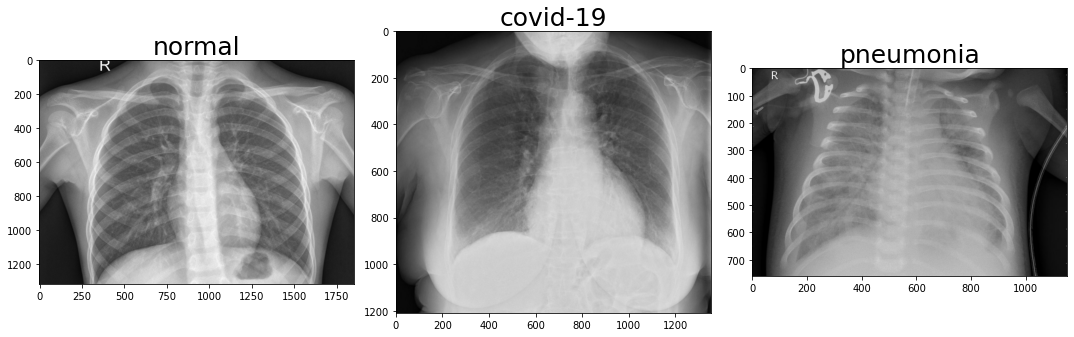

In [8]:
 # A quoi ressemble les images?
    
example_normal = os.listdir(os.path.join(train_path,  'normal'))[0]
example_covid = os.listdir(os.path.join(train_path, 'covid'))[3]
example_pneumonia = os.listdir(os.path.join(train_path,  'pneumonia'))[0]

normal_img = plt.imread(os.path.join(train_path, 'normal\\' + example_normal))
covid_img = plt.imread(os.path.join(train_path, 'covid\\' + example_covid))
pneumonia_img = plt.imread(os.path.join(train_path, 'pneumonia\\' + example_pneumonia))


fig, axes = plt.subplots(1, 3, figsize = (15, 20))
fig.tight_layout()

axes[0].imshow(normal_img)
axes[0].set_title('normal', fontsize = 25)
axes[1].imshow(covid_img)
axes[1].set_title('covid-19', fontsize = 25)
axes[2].imshow(pneumonia_img)
axes[2].set_title('pneumonia', fontsize = 25)
    

Images gris de taille différente. A noter que Matplotlib (utilisé pour lire les images), traite toutes les images comme ayant trois canaux de couleur (Rouge, Vert et Bleu), même si l'image est gris (un canal). Dans ce cas, les trois canaux de couleur sont identiques pour chaque pixel de l'image comme on peut constater dans l'exemple ci-dessous

In [9]:
normal_img[0][0]

array([32, 32, 32], dtype=uint8)

### Distribution des pixels

Dimensions de l'image: 1317 pixels en largeur et 1855 pixels en hauteur
Valeur maximum de pixels :255.00, valeur minimale :0.00
Moyenne des pixels : 131.14 et standard deviation : 56.98


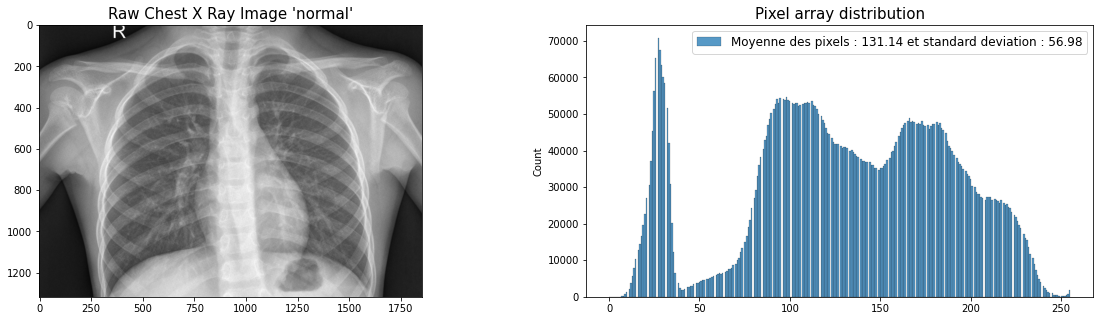

In [10]:
# Exemple image brut 'normal'

print(f"Dimensions de l'image: {normal_img.shape[0]} pixels en largeur et {normal_img.shape[1]} pixels en hauteur")
print(f"Valeur maximum de pixels :{normal_img.max():.2f}, valeur minimale :{normal_img.min():.2f}")
print(f"Moyenne des pixels : {normal_img.mean():.2f} et standard deviation : {normal_img.std():.2f}")

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].set_title("Raw Chest X Ray Image 'normal'", fontsize = 15)
ax[0].imshow(normal_img, cmap="bone")
ax[1].set_title("Pixel array distribution", fontsize = 15);
sns.histplot(normal_img.flatten(), label = f"Moyenne des pixels : {normal_img.mean():.2f} et standard deviation : {normal_img.std():.2f}", ax=ax[1])
ax[1].legend(loc='upper right', fontsize = 12)


Avant d'entrainer notre modèle, je vais procéder au pré-traitement des images pour les redimensionner et normaliser et les valeurs des pixels.

# Prétraitement d'images - preprocessing

Pour préparer les données d'image à l'entrée du modèle, un prétraitement est nécessaire. Cette étape est très importante et permet d'améliorer la performance, la vitesse de convergence et la capacité de généralisation du modèle. Par exemple, les couches CNN exigent que toutes les images soient dans des tableaux de la même taille. 
Un prétraitement inclut, mais n'est pas limité à :  

- Normalisation : mise à l'échelle des valeurs de pixels, généralement entre 0 et 1 (/255 valeur maximale des pixels).

- Redimensionnement : généralement à la même taille d'images dont le modèle CNN a été préentrainé. Cependant, les implémentations modernes peuvent gérer différentes dimensions d'entrée. Si on utilise une taille différente de celle du préentrainement, on doit toujours respecter le format carré d'images d'entrée et que la taille ne soit pas trop petite au risque de perdre des caractéristiques importantes

- Augmentation de données : L'augmentation de données consiste à créer de nouveaux échantillons d'entraînement en appliquant des transformations telles que la rotation, le recadrage, le retournement et la modification de la luminosité. Cela aide le modèle à mieux généraliser

- Répartition des données ou data splitting  : La division de l'ensemble de données en ensembles d'entraînement et de validation est considérée comme une forme de prétraitement. Cela permet d'évaluer les performances du modèle sur les données de validation avant l'évaluation finale sur les données de test. 

Selon la qualité des images, des techniques de réduction du bruit pourraient être nécessaires pour améliorer la qualité des données d'entrée. Aussi il faut faire attention au nombre de canaux de couleur comme certains modèles s'attendent à ce que les images en aient 3 (pour les images RGB). 


## ImageDataGenerator
Pour effectuer le prétraitement, je vais utiliser la classe ImageDataGenerator de Keras avec .flow_from_directory qui permet de charger les images à partir de répertoires organisés en sous-répertoires comme la structure illustrée ci-dessous (pour une classification binaire). La structure doit respecter que le répertoire principal contient au moins deux dossiers, un pour l'entraînement (train) et un pour les tests (test). Le dossier train devrait contenir n sous-dossiers, chacun contenant des images de la classe respective et le dossier de test devrait contenir un seul dossier contenant toutes les images de test.

<div>
<img src="ImageDatagen.jpeg" style="width: 500px;"/>
</div>



Cette classe permet de réaliser diverses augmentations sur les images existantes telle que le retournement horizontal aléatoire des images si aucune transformation d'augmentation a été configurée. Les images sont chargées en lot (batch) et les transformations d'augmentation sont appliquées à chaque image individuellement dans le lot. Elles sont normalisées et redimensionnées à la taille préconfigurée et les étiquettes de classe (labels) sont attribuées automatiquement à partir de la structure des sous-répertoires. Chaque sous-répertoire est associé à une classe et les images qu'il contient sont étiquetées en conséquence.  

In [11]:
# Initialiser la classe ImageDataGenerator de Keras
# normaliser et Utiliser 20% des données pour la cross-validation

image_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2) 

In [12]:
# Initialiser le génerateur d'entrainement
# Générer un lot de d'images (batch) de 40 images
# Effectuer le redimensionnement et un shuffling (brassage)

train_generator = image_generator.flow_from_directory(batch_size = 40,
                                                     directory = train_path, 
                                                     shuffle = True,        # shuffling the order of the image
                                                     target_size = (256,256), 
                                                     class_mode = 'categorical', 
                                                     subset = "training",
                                                     seed = 42) # Random seed for applying random image augmentation and shuffling the order of the image

Found 363 images belonging to 3 classes.


In [13]:
# Initialiser le génerateur de validation 

validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = train_path, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation",
                                                           seed = 42)

Found 90 images belonging to 3 classes.


In [14]:
# Générer un lot de 40 images et étiquettes/labels (associer les labels aux images)

train_images, train_labels = next(train_generator)

In [15]:
train_images.shape

(40, 256, 256, 3)

In [16]:
train_labels[0]

array([0., 1., 0.], dtype=float32)

In [17]:
# labels 
label_names = train_generator.class_indices
label_names

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [18]:
# Inverser les clés et les valeurs dans label_name pour utilisation plus simple

label_names = dict((v,k) for k,v in label_names.items())
label_names

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

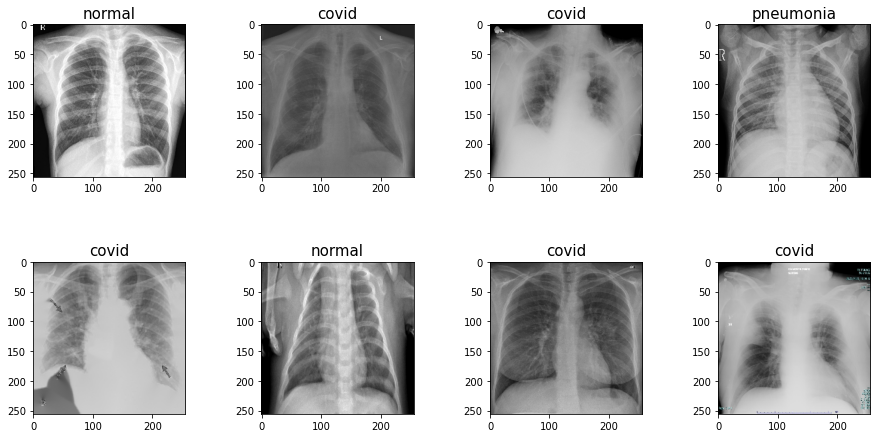

In [19]:
# Visualisation des images prétraitées et de leurs labels 'class'

L = 2
W = 4

fig, axes = plt.subplots(L, W, figsize = (15, 8))
axes = axes.ravel()  # flatten axes-->1d

for i in range(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])], fontsize=15) # np.argmax trouve l'index de l'element max dans le tableau
    
plt.subplots_adjust(wspace = 0.5)

plt.savefig('Images pretraitees', dpi=200, bbox_inches='tight')

# Les réseaux de neurones convolutifs (CNN) 

Les réseaux de neurones convolutifs (Convolutional Neural Networks, CNN) désignent une sous-catégorie de réseaux de neurones spécialement conçus pour traiter des images en entrée. En raison de leur capacité à analyser les pixels et leur voisinage, les CNN sont les réseaux les plus utilisés dans les tâches de classification et de segmentation en vision par ordinateur et en imagerie médicale. Leur architecture peut disposer de dizaines, voire de centaines de couches et comporte deux parties bien distinctes comme illustré sur l'image ci-dessous:

<p align="center"><img src="images/CNN-parts.png" style="width: 700px"/></p>

* Une partie convolutive (Convlutional layers) spécifique au CNN : Elle fonctionne comme un extracteur des caractéristiques propres à chaque image (features) en appliquant des opérations de filtrage par convolution et en les compressant de façon à réduire leur taille initiale. Cette partie de traitement est constitué d'une à plusieurs couches dont les plus courantes sont : 
    - Couche de convolution (CONV) : applique un ensemble de filtres convolutifs aux images en entrée   
    - Couche de correction (ReLU, Rectified linear unit) ou d'activation : remplace les valeurs négatives par des zéros et conserve les valeurs positives ce qui favorise un apprentissage plus rapide et plus efficace   
    - Couche de pooling (POOL) : simplifie la sortie en réalisant une compression de l'information en réduisant la taille de l'image tout en préservant leurs caractéristiques les plus essentielles. Ce qui permet de réduire le nombre de paramètres que le réseau doit apprendre.    
    
Les valeurs des dernières features obtenues à la fin de cette premiere partie sont concaténées dans un vecteur de caractéristiques appelé code CNN. Ce vecteur définit l'entrée de la seconde partie de classification. 

* Une partie classification (Fully connected (dense) layers) commun à tous les réseaux de neurones utilisés pour la classification: Elle est constituée de couches entièrement connectées et son rôle est de combiner les caractéristiques du code CNN afin de classer l’image. 

Une fonction de perte (loss function) est associée à la couche finale pour calculer l'erreur de classification. Il s'agit en général de l'entropie croisée (crossentropy) qui est à minimiser lors de la phase d'entraînement. Comme pour les réseaux de neurones ordinaires, les paramètres des couches ici les valeurs des poids sont ajustés par rétropropagation du gradient afin de minimiser la fonction de perte. En d'autres termes, en partant de la fin du réseau, on calcule itérativement pour chaque couche, qu'il s'agisse d'une couche de convolution, d'une couche de pooling ou d'une couche entièrement connectée, les poids afin de minimiser l'erreur entre les prédictions du modèle et les valeurs réelles des données d'entraînement.

##  Comprendre l'apprentissage par transfert ou transfer learning

Le Transfer Learning est une méthode d’apprentissage de machine learning qui consiste à initialiser les paramètres d’un réseau à l’aide des paramètres d’un modèle déjà entraîné sur une autre tâche plutôt que par des paramètres aléatoires.
En d'autres termes, au lieu de construire un modèle à partir de zéro, on prend un modèle qui a été développé et entraîné sur de larges bases de données comme Imagenet (des millions d'images) comme point de départ pour pour notre classification d'images. Ainsi, le réseau tire parti de ce modèle pré-entraîné qui avait déjà appris à reconnaître des formes, des motifs et des caractéristiques dans des images et converge généralement plus vite, avec beaucoup moins de données. Cela permet de gagner du temps et d'économiser de ressources de calcul, l'amélioration des performances et la prévention du surapprentissage (overfitting) en réduisant le nombre de paramètres à ajuster.
L'image ci-dessous illustre l'utilisaton du transfer learning pour la classification d'images. 

<p align="center"><img src="images/TLbyR.png" style="width: 700px"/></p>

credits image R. Ahmad

Dans le domaine des réseaux de neurones, les paramètres transférés sont les poids du réseau. Il existe plusieurs variantes dans lesquelles on gèle certains des poids du réseau afin de ne réentraîner qu’une partie du réseau. En effet, il existe généralement deux approches principales en transfer learning :

- Feature Extraction (Extraction de Caractéristiques): On utilise les caractéristiques apprises par un modèle pré-entraîné comme entrée pour un nouveau modèle adapté à la tâche cible. L’idée est donc de réutiliser un réseau pré-entraîné sans sa couche finale en ajoutant des couches de classification spécifiques à la nouvelle tâche. 

- Fine-Tuning (Ajustement de modèles pré-trainés) : Dans laquelle non seulement la dernière couche est remplacée pour réaliser la classification, mais d’autres couches sont également ré-entraîner de manière sélective. En général, pendant l’entraînement on gèle (freeze) les premières couches (et donc leurs poids) du modèle pré-entraîné, car ces couches capturent généralement des caractéristiques  génériques comme les bords, les textures, etc., et sont souvent utiles à transférer. En revanche, les couches plus profondes qui captent des caractéristiques plus spécifiques à la tâche d'entraînement initiale sont ré-entraînées et ajustées pour qu'elles soient adaptées à la nouvelle tâche.

Dans la suite, je vais réaliser un fine-tuning du réseau ResNet50 avec keras. Il s’agit d’un réseau de classification d’images avec des poids formés sur ImageNet et qui a montré une importante performance dans le domaine de l'imagerie médicale.

# ResNet50 en transfer learning

## Architecture du réseau ResNet50

Comme illustré sur l'image ci-dessous et comme son nom le suggère, RestNet50 (Residual Neural Network) se compose de 50 couches si l'on compte toutes les couches de convolution et les couches entièrement connectées, c-a-d on compte les couches qui contiennent le plus grand nombre de paramètres ajustables (on ne compte pas les couches d'activation et de pooling max/moyennes). Les couches convolutives sont organisées en 5 blocs résiduels (ou stage), et chaque bloc peut contenir plusieurs couches convolutives, de normalisation, et d'activation. ResNet-50 possède environ 25 millions paramètres! 


<p align="center"><img src="images/architecture-resnet50.png" style="width: 700px"/></p>

Les blocs résiduels ont été introduits avec les réseaux ResNet pour surmonter le problème du vanishing gradient (disparition du gradient) lié à l'entraînement de réseaux de neurones extrêmement profonds impliquant la rétropropagation et l’apprentissage par gradient. En effet, lorsqu'on effectue une rétropropagation pour calculer les gradients et mettre à jour les poids, le gradient est calculé en utilisant la règle de la chaîne (chain's rule), où les gradients des couches précédentes sont multipliés les uns par les autres (la dérivée de chaque couche précédente est calculée en fonction de celle de la couche suivante). Lorsque le gradient devient extrêmement petit au fur et à mesure qu'il se propage vers les couches profondes, l'ajustement des poids couches devient presque insignifiantes, ce qui peut entraîner une convergence lente ou une stagnation de l'apprentissage.
C'est là que les architectures comme les blocs résiduels sont utiles. Les connexions résiduelles permettent aux informations de contourner/sauter certaines couches (3 pour ResNet50), réduisant ainsi le problème du vanishing gradient.

<div>
<img src="images/bottleneckresnet.png" style="width: 500px;"/>
</div>

##  Création du modèle

Pour réaliser le transfer learning, on va transférer les poids du modèle déjà entraîné à notre propre jeu de données. je vais geler (freeze) les couches jusqu'au les 10 dernières cad jusqu'au 4ème bloc (voir schema de l'architecture du modèle ou j'ai marqué freeze). Les poids de ces couches transférés vont rester les memes et seuls les poids des 10 dernières couches vont être ajustés en apprenant sur les nouvelles données.

In [20]:
# Chargement du modèle Resnet50 pré-entraîné sur imagenet avec Keras
model_rsnt = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))

Définir include_top = False signifie qu'on exclue le fully connected layer FC (top layer) et cela permettra d'ajouter ainsi des couches personnalisées à notre problème et qu'on va les définir dans la suite     
Le paramètre weights='imagenet' spécifie qu'on initialise les poids du modèle à partir des poids appris sur la base ImageNet lors du pré-entraînement

In [21]:
model_rsnt.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [32]:
# Gel les 4 blocks (re-entraine block 5) 

for layer in model_rsnt.layers[:-10]:
    layer.trainable = False

J'ajoute la couche de classification (Top Layer) sur le réseau qui consiste en :
- Une couche AveragePooling
- Applatissement de l'image de sortie du modèle de convolution pour chaque image en un vecteur pour l'entrée du classifier 
- Ajout de 2 couches de 256 et 128 neurones respectivement avec une fonction d’activation « relu »
- Ajout de 2 couches de régularisation "Dropout" avec une probabilité d'abandon de 30 % et 20% respectivement. Le Dropout, ou abandon, est une technique de régularisation où des neurones sélectionnés aléatoirement sont ignorés pendant l'entraînement du modèle dans le but de prévenir l’overfitting. 
- Ajout de la couche de sortie à trois neurones pour la prédiction 

In [33]:
# Ajouter les couches de classification 
outp_model = model_rsnt.output
outp_model = AveragePooling2D(pool_size = (4,4))(outp_model)
outp_model = Flatten(name = 'flatten')(outp_model) # 1D pour l'entree de la couche dense
outp_model = Dense(256, activation = 'relu')(outp_model) # 256 neurones
outp_model = Dropout(0.3)(outp_model)   # Dropout regularization 
outp_model = Dense(128, activation = 'relu')(outp_model) # 256 neurones
outp_model = Dropout(0.2)(outp_model)
# output layer: nombre de neurones de sortie = nombre de classe a prédire (3 classes)
outp_model = Dense(3, activation = 'softmax')(outp_model) 
model = Model(inputs = model_rsnt.input, outputs = outp_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

On note le nombre de paramètres pré-entrainés (19,122,048) gelés et qu'on va les réutiliser. On remarque aussi toutes les couches du Resnet50 en amont et les couches qu'on a ajoutées au top. 

In [34]:
# Compilation du modèle
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4, decay = 1e-6), metrics= ["accuracy"])

## Entrainement du modèle

In [35]:
# Sauvegarder les meilleurs poids du modèle (loss plus faible)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
# Arrêt anticipé si val_loss cesse de diminuer (min) apres certains epoch (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [36]:
train_gen = image_generator.flow_from_directory(batch_size = 3, directory= train_path, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training", seed=42)
val_gen = image_generator.flow_from_directory(batch_size = 3, directory= train_path, shuffle = True, target_size=(256,256), class_mode= 'categorical', subset="validation", seed=42)

Found 363 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [37]:
# Entraînement avec nos données

history = model.fit(train_gen, steps_per_epoch= train_gen.n // 3, epochs = 10, validation_data= val_gen, validation_steps= val_gen.n // 3, callbacks=[checkpointer, earlystopping]) #


Epoch 1/10
121/121 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9256
Epoch 1: val_loss improved from inf to 0.26759, saving model to weights.hdf5
121/121 [==============================] - 114s 908ms/step - loss: 0.2391 - accuracy: 0.9256 - val_loss: 0.2676 - val_accuracy: 0.8889
Epoch 2/10
121/121 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.9780
Epoch 2: val_loss improved from 0.26759 to 0.21229, saving model to weights.hdf5
121/121 [==============================] - 98s 812ms/step - loss: 0.0492 - accuracy: 0.9780 - val_loss: 0.2123 - val_accuracy: 0.9444
Epoch 3/10
121/121 [==============================] - ETA: 0s - loss: 0.0200 - accuracy: 0.9972
Epoch 3: val_loss did not improve from 0.21229
121/121 [==============================] - 99s 820ms/step - loss: 0.0200 - accuracy: 0.9972 - val_loss: 0.2242 - val_accuracy: 0.9444
Epoch 4/10
121/121 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 4:

## Evaluation du modèle

Maintenant que notre modèle a été entrainé nous allons pouvoir l'évaluer et lui demander de faire les prédictions sur nos images de tests

In [38]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(
                directory=test_path,
    target_size=(256, 256),
    batch_size=1,
    shuffle=False,
    seed=42
)

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
evaluate = model.evaluate(test_generator, 
                          steps = STEP_SIZE_TEST,
                          verbose=1)


print(f"Accuracy Test : {evaluate[1]}")

Found 30 images belonging to 3 classes.
30/30 [==============================] - 8s 253ms/step - loss: 0.0698 - accuracy: 0.9667
Accuracy Test : 0.9666666388511658


In [39]:
# Génération des prédictions

test_generator.reset() 
pred = model.predict(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose=1)

predicted_class_indices=np.argmax(pred,axis=1) 

30/30 [==============================] - 9s 222ms/step


In [40]:
predicted_class_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1], dtype=int64)

In [41]:
pred[0]

array([1.0000000e+00, 2.9958462e-12, 3.8515106e-14], dtype=float32)

In [42]:
# map the predicted labels with their unique ids such as filenames to find out what you predicted for which image
# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
predictions = [label_names[k] for k in predicted_class_indices]

In [43]:
#plt.imread(os.path.join(test_path, 'images\\' + example_normal))
Real = []
for i in range(len(os.listdir(test_path))):
    for item in os.listdir(os.path.join(test_path, os.listdir(test_path)[i])):
        Real.append(os.listdir(test_path)[i])

In [44]:
print(classification_report(np.asarray(Real), np.asarray(predictions)))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        10
      normal       0.91      1.00      0.95        10
   pneumonia       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



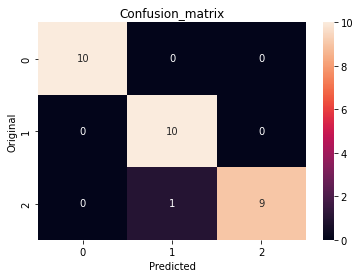

In [45]:
# matrice de confusion

cm = confusion_matrix(np.asarray(Real), np.asarray(predictions))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

plt.savefig('confusion matrix 30', dpi=200, bbox_inches='tight')

#### Visualisation des images avec leurs vrai labels et ceux predits

In [46]:
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_path))):
#     for(pathtest, dirtest, filtest) in os.walk(test_path):
    for item in os.listdir(os.path.join(test_path, os.listdir(test_path)[i])):
  #for item in os.listdir(os.path.join(test_path+"\images",str(i))):
        img= cv2.imread(os.path.join(test_path, os.listdir(test_path)[i], item) )
        img = cv2.resize(img,(256,256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1,256,256,3) # conserver le nombre total d'image dans le tableau tout en redimensionnant les dimensions en 256x256x3 
        predict = model.predict(img)
        
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(os.listdir(test_path)[i])

1/1 [==============================] - 0s 238ms/step


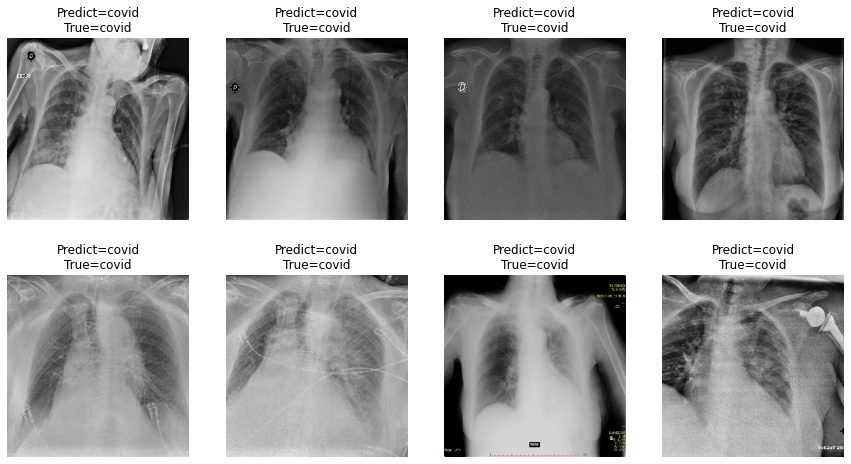

In [47]:
L = 2
W = 4

fig, axes = plt.subplots(L, W, figsize = (15, 8))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Predict={}\nTrue={}".format(label_names[prediction[i]], original[i]))
    axes[i].axis('off')
plt.savefig('images predicted', dpi=200, bbox_inches='tight')

## Tester le modele sur les 1000 images du dataset test


In [48]:
test_path_1000 = path + '\datasets\covid-pneumonia-normal\Data\\test'

In [50]:
# Count all files in the directory and its subdirectories
count = 0
for(path, dirnames, filnames) in os.walk(test_path_1000):
    count += len(filnames)
print(f"nombre d'image total dans test set : {count}")

nombre d'image total dans test set : 1288


In [51]:
os.listdir(test_path_1000)

['covid', 'normal', 'pneumonia']

In [52]:
# fonction de genrer images test, predire et evaluer le modele
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(
    directory=test_path_1000,
    target_size=(256, 256),
    #color_mode="rgb",
    batch_size=46,
    #class_mode=None,# if images non classés dans folder
    shuffle=False,
    seed=42)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
evaluate = model.evaluate(test_generator, 
                          steps = STEP_SIZE_TEST,
                          verbose=2)


print(f"Accuracy Test : {evaluate[1]}")



Found 1288 images belonging to 3 classes.
28/28 - 199s - loss: 1.2939 - accuracy: 0.8921 - 199s/epoch - 7s/step
Accuracy Test : 0.8920807242393494


In [53]:
test_generator.reset()
pred = model.predict(test_generator,
                    steps = STEP_SIZE_TEST,
                    verbose=2)

28/28 - 191s - 191s/epoch - 7s/step


In [56]:
Reals, predictions = map_label_pred_true(test_path_1000, pred, labels)

In [57]:
confusion_matrix(np.asarray(Reals), np.asarray(predictions))

array([[116,   0,   0],
       [  3, 285,  29],
       [ 34,  73, 748]], dtype=int64)

In [73]:
clsf_report = pd.DataFrame(classification_report(Reals, predictions, output_dict=True)).transpose()
#clsf_report.to_csv('classification-report.csv', index= True)
clsf_report

,precision,recall,f1-score,support
covid,0.758170,1.000000,0.862454,116.000000
normal,0.796089,0.899054,0.844444,317.000000
pneumonia,0.962677,0.874854,0.916667,855.000000
accuracy,0.892081,0.892081,0.892081,0.892081
macro avg,0.838979,0.924636,0.874522,1288.000000
weighted avg,0.903258,0.892081,0.894009,1288.000000


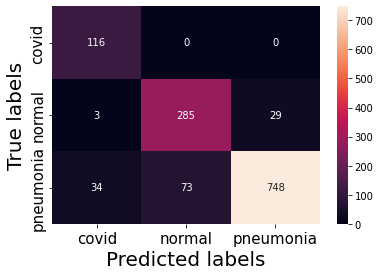

In [60]:
conf_mat(Reals, predictions,test_path_1000 )
plt.savefig('conf matrix tot', dpi=200, bbox_inches='tight')

In [116]:
# sauvegarder le modele
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5 (Hierarchical Data Format conçu pour stocker et gérer de grandes quantités de données structurées de manière hiérarchique)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


J'envisage re-entrainer le modele sur le dataset complet de 5145 images 
Tester un autre optimizer (ADAM). Il utilise des moments pour ajuster les taux d'apprentissage des poids et pour prendre en compte la dynamique du gradient
La bibliothèque keras possède également de nombreux modèles pré-entraînés que je pourrais tester